# 第八章：第三次上机实验

<h3>本次上机实验的目标是：</h3>
<ul>
<li>探索在各种图像上做局部平均的效果。</li>
    <li>查看如何使用这种平均对图像降噪。</li>
    <li>使用特定的滤波器增强指定的图像特性。</li>
</ul>

## 8.1 卷积

我们在《概率论与数理统计》中学过卷积，两个随机变量和的分布是一个卷积公式. 这里我们来看一下卷积的一些应用

对图像数组$I$使用滤波器数组$F$做二维离散卷积$C$的通用定义是:
    $$C_{i,j}=\sum_{k,l}F_{k,l}I_{i-k,j-l}$$
求和的范围是所有分别指向数组$F$和$I$的合法条目的$k$值和$l$值.

#### 练习8A

(a) 考虑一个小转换，其中数组$F$是一个$1\times1$的矩阵, 唯一的元素是1. 解释为什么在这种情况下数组$C$和$I$是相同的？

答：因为$F$只有一个元素且值为1, 那么$k,l$的取值均为0，$i-k,j-l$的范围就是原来$I$数组的下标范围, 又因为$F$的值为1, 所以$C$和$I$大小和形状相同.

(b) 假定数组$F$的大小是$m\times n$, 数组$I$的大小是$M\times N$. 解释为什么数组$C$的大小是$(M+m-1)\times(N+n-1)$?

答：$C$的大小可以由$i,j$的变化范围确定, $i,j$的最小值均为0，当$k$取到最大值$m-1$时，$i-k$的最大值是$M-1$, $i$的最大值是$M+m-2$, 即$i$的变化范围是[0,$M+m-2$], 一共$M+m-1$个元素, 同理可得$j$的变化范围.

### 8.1.1 Python的图像处理工具

scipy.ndimage是SciPy下面的一共图像函数库, 我们把它导入成sim

sim.convolve是scipy.ndimage中的一个函数，用help可以看到更多的信息

我们来探索一下卷积的应用.

In [1]:
import scipy.ndimage as sim, numpy as np, matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
%config InlineBackend.figure_format = 'retina'

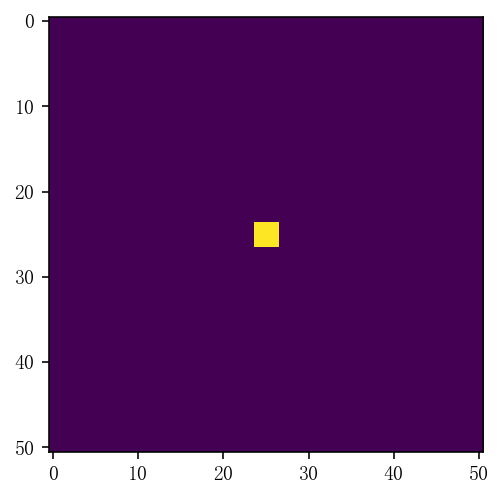

In [2]:
impulse = np.zeros((51, 51)) #产生一个2维零数组
impulse[25,25] = 1.0         #二维零数组的中间点值设为1
my_filter_small = np.ones((3,3))/9     #设置一共均匀的方形数组，数组所有值的和为1
response = sim.convolve(impulse, my_filter_small)  #调用函数做卷积
plt.imshow(response)

impulse和response两个数组大小一样, 这个是sim.convolve的缺省设置mode='reflect', 通过help可以查看其它选择.

由公式(8.1)：

$C[0,0]=F[0,0]\times I[0,0],$

$C[M+m-2, N+n-2] = F[m-1, n-1]\times I[M-1, N-1]$

所以卷积生成的图像边缘会产生失真. mode='reflect'会对边缘进行修剪, 返回卷积图像的中心部分.

### 8.1.2 图像平均

一个简单的滤波器会对每个指定区域中的点分配同样的权重。在卷积后的图像中，每个点是原始图像中近邻点的平均值

获取数据集16catphoto的图像

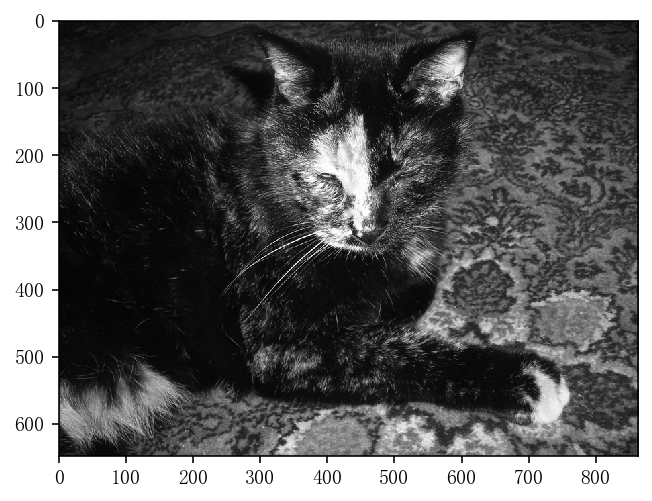

In [3]:
filepath = r'D:\我的课程\计算物理\Datasets\16catphoto\\'
photo = plt.imread(filepath + 'bwCat.tif')
plt.imshow(photo,cmap='gray')

#### 任务

##### (a) 用前面例子定义的滤波器，调用sim.convolve做卷积, 并与sim.uniform_filter做比较

Wall time: 17 ms


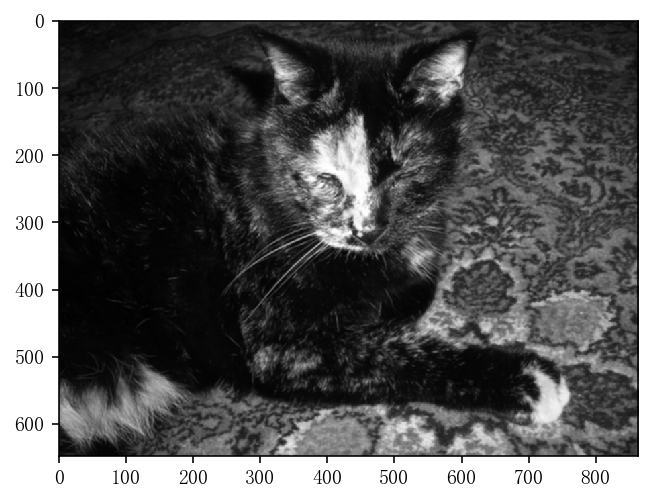

In [4]:
%%time
#这里%%time是ipython的魔法命令, 可以返回程序运行时间估计
plt.figure('sim.convolve')
response= sim.convolve(photo, my_filter_small)
plt.imshow(response,cmap='gray')

Wall time: 16 ms


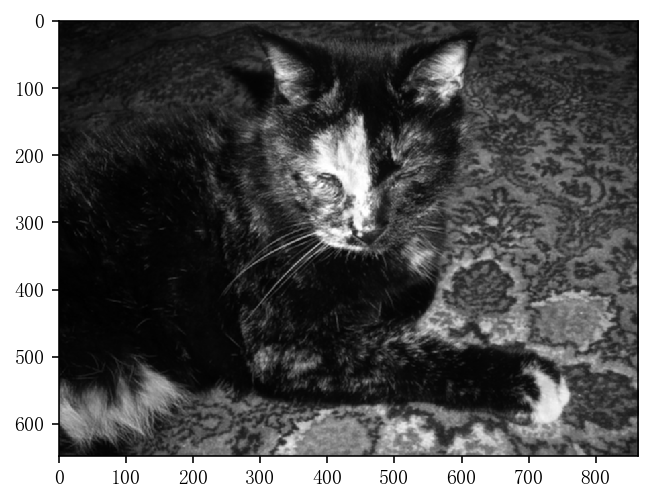

In [5]:
%%time
response2 = sim.uniform_filter(photo) #使用程序库自带均匀滤波器
plt.figure('uniform_filter')
plt.imshow(response2,cmap='gray')

##### (b) 使用一个具有适当值的$15\times 15$的数组，构成一共大正方形滤波器, 重复(a)中的操作

Wall time: 147 ms


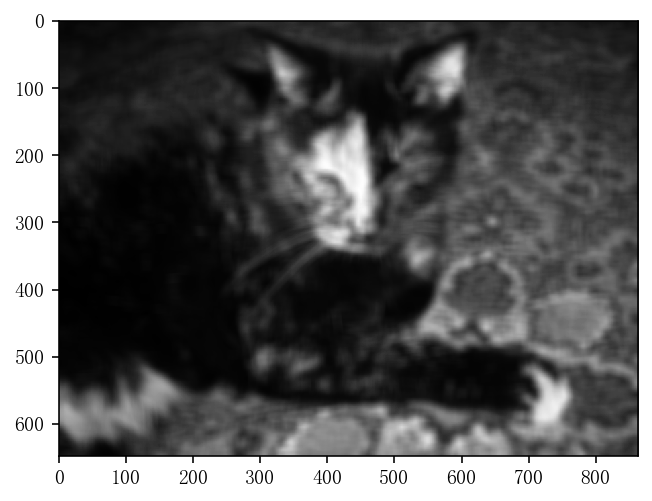

In [6]:
%%time
my_filter_big = np.ones((15,15))*1/225
response = sim.convolve(photo, my_filter_big)
plt.figure('big filter')
plt.imshow(response, cmap='gray')

Wall time: 20.5 ms


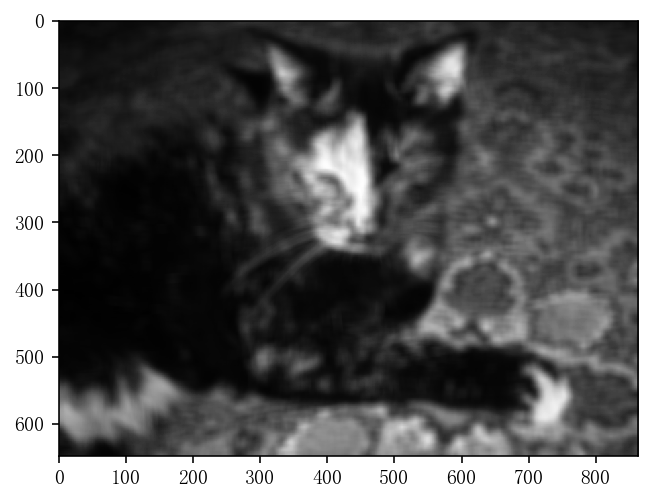

In [7]:
%%time
response2 = sim.uniform_filter(photo,size=15)
plt.figure('uniform_filter')
plt.imshow(response2,cmap='gray')

##### (c) 使用公式(8.1)的定义编写程序， 显示卷积生成的图像，图像中的每个点是原始图像中邻近像素的平均值.

In [9]:
def myConvolve(func,img):
    """
    公式(8.1) C_{i,j} = sum_{k,l}{F_{k,l}*I_{i-k,j-l}}
    """
    ni, nj = img.shape
    nk, nl = func.shape
    c = np.zeros((ni+nk-1, nj+nl-1))
    for i in range(ni+nk-1):
        for j in range(nj+nl-1):
            s = 0.
            for k in range(min(i, nk)):
                for l in range(min(j, nl)):
                    if (i-k)<ni and (j-l)<nj:
                        s += func[k,l]*img[i-k, j-l]
            c[i,j] = s
    return c

In [12]:
%%time
response = myConvolve(photo, my_filter_small)
plt.figure('my Convolve')
plt.imshow(response, cmap='gray')

KeyboardInterrupt: 

### 8.1.3 使用高斯滤波器做平滑

高斯滤波是一种略微复杂的滤波器, 和均匀滤波器的区别是原始图像点的权重不同.

##### 导入数据: gauss_filter.npy

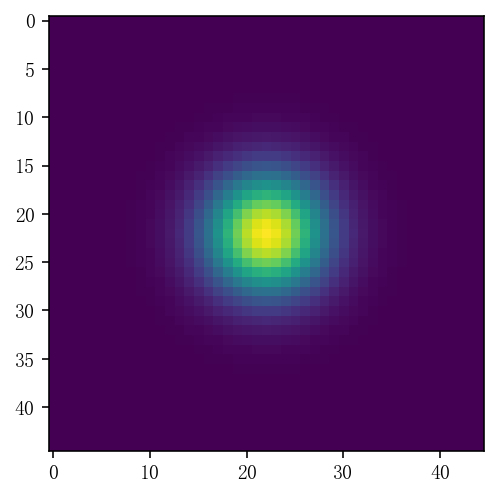

In [13]:
#gauss_filter.csv
filepath = r'D:\我的课程\计算物理\Datasets\16catphoto\\'
gauss = np.load(filepath + 'gauss_filter.npy')
plt.imshow(gauss)

#### 任务：

##### (a) 显示原始图像的高斯卷积（尝试使用sim.gauss_filter函数， 使用关键字参数 "sigma = 5"）

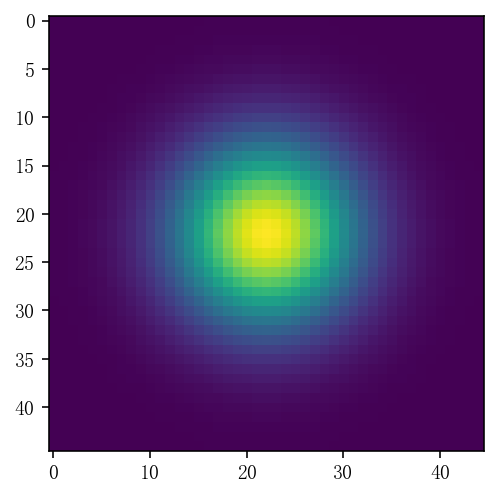

In [14]:
smooth = sim.gaussian_filter(gauss, sigma=5)
plt.figure('smooth')
plt.imshow(smooth)

##### (b) 调用plt.imshow函数，比较使用高斯滤波器的单一点卷积与实验8.1.2(b)所使用的正方滤波器

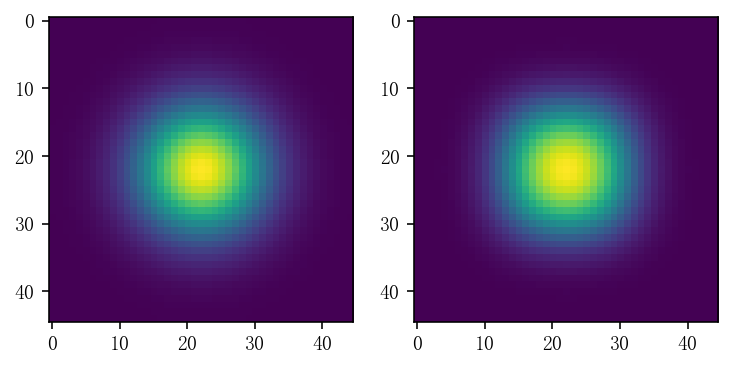

In [15]:
fig = plt.figure('square')
gauss_filter = sim.gaussian_filter(gauss,sigma=5)
plt.subplot(1,2,1)
plt.imshow(gauss_filter)
plt.subplot(1,2,2)
square_big = sim.convolve(gauss, my_filter_big)
plt.imshow(square_big)

##### (c) 调用plot_surface, 从3个维度上查看实验(b)中的卷积图像。使用卷积的定义介绍原因，然后解释使用高斯滤波器和正方滤波器有哪些不同，在哪些情况下人们更倾向高斯滤波器。

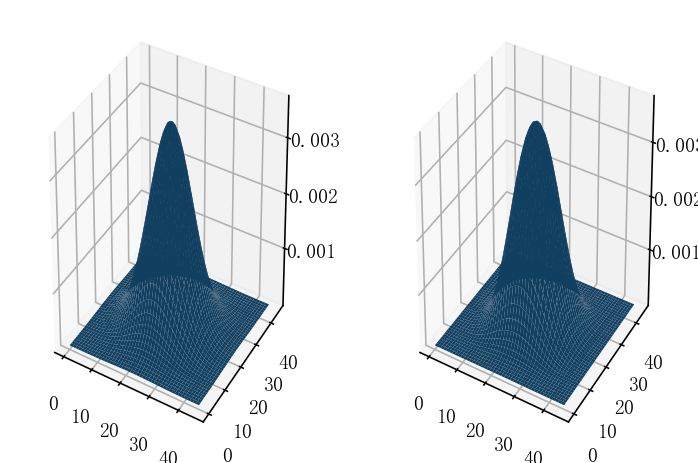

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure('gauss')
ax1 = fig.add_subplot(121, projection='3d')
x, y = np.mgrid[0:45:45j, 0:45:45j]
ax1.plot_surface(x, y, smooth)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, square_big)

## 8.2 图像去噪

#### 任务

##### (a) 对原始图像的每个点乘以一个介于0和1之间的随机数，然后将所得的的矩阵按上述步骤进行转换，比较生成的噪声图像和原始图像

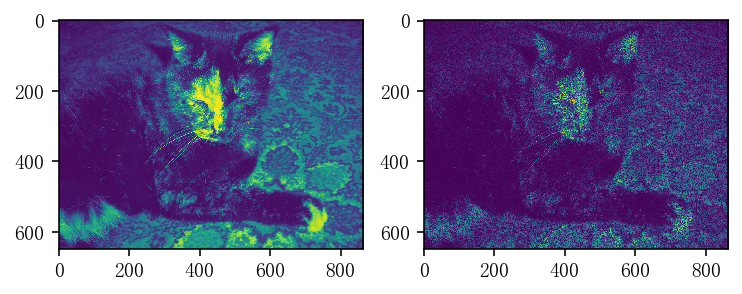

In [17]:
x, y = photo.shape #图像的形状
noise = np.random.random((x,y))  #产生[0，1]之间的随机噪声
Photo_noise = photo*noise     #给原数据添加噪声
mi = Photo_noise.min()
ma = Photo_noise.max()
Photo_noise = (Photo_noise-mi)/(ma-mi)*255
Photo_noise = Photo_noise.astype('uint8')
fig, axes = plt.subplots(1,2)
axes[0].imshow(photo)
axes[1].imshow(Photo_noise)

##### (b) 将8.1.2和8.1.3中给出的每个滤波器(小正方形滤波器，大正方形滤波器和高斯滤波器)应用到实验(a)生成的噪声图像上。哪个滤波器的效果最好？

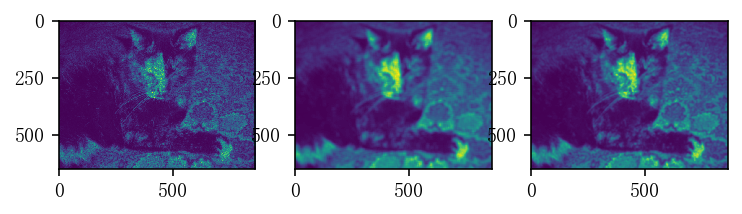

In [18]:
fig, axes = plt.subplots(1,3)
small_square = sim.uniform_filter(Photo_noise, size = 3)  #小正方滤波器
axes[0].imshow(small_square)
big_square = sim.uniform_filter(Photo_noise, size = 15)   #大正方滤波器
axes[1].imshow(big_square)
gauss = sim.gaussian_filter(Photo_noise, sigma=3)         #高斯滤波器
axes[2].imshow(gauss)

## 8.3 特征强调

##### 获取数据集17stressFibers

In [19]:
filepath = r'D:\我的课程\计算物理\Datasets\17stressFibers\\'
stressFibers = np.load(filepath + 'stressFibers.npy')

##### 调整数组比例

经实践发现调整数组比例会产生比较奇怪的结果，所以最终选择不调整

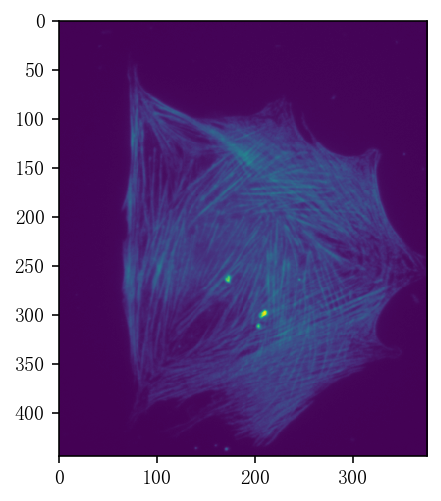

In [20]:
#smin, smax = stressFibers.min(), stressFibers.max()
#stressFibers = (stressFibers - smin)/(smax-smin)*255
#stressFibers = stressFibers.astype('uint8')
plt.figure('original')
plt.imshow(stressFibers)

#### 任务：

##### (a) 执行下面的代码，并绘制滤波器的曲面图，描述其中的显著特性

Text(0.5, 0, 'y')

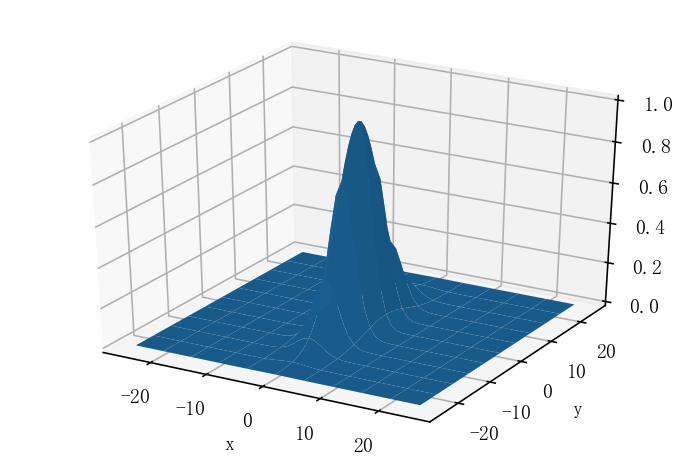

In [21]:
from mpl_toolkits.mplot3d import Axes3D
v = np.arange(-25, 26)
X, Y = np.meshgrid(v, v)
gauss_filter = np.exp(-0.5*(X**2/5 + Y**2/45))
fig = plt.figure('Gauss filter')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, gauss_filter, rstride=5, cstride=5)
ax.set_xlabel('x')
ax.set_ylabel('y')

##### (b) 使用下面的“黑箱”代码修改实验(a)中的滤波器，然后使用生成的滤波器绘制曲面图，比较combined_filter和gauss_filter之间的共性和差异

In [22]:
laplace_filter=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
combined_filter = sim.convolve(gauss_filter, laplace_filter)

Text(0.5, 0, 'y')

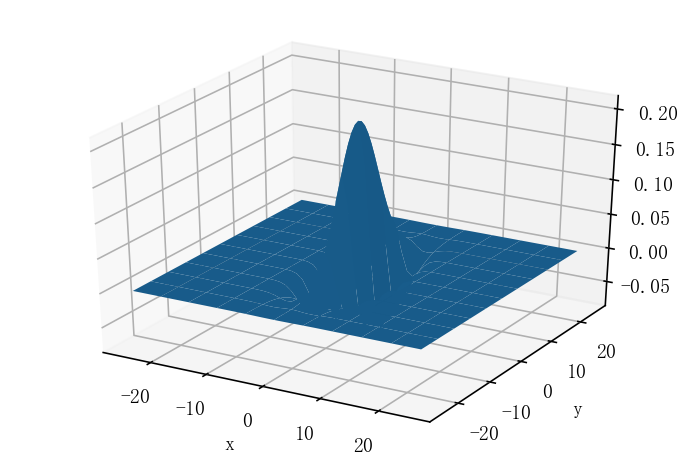

In [23]:
fig = plt.figure('combined filter')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, combined_filter, rstride=5, cstride=5)
ax.set_xlabel('x')
ax.set_ylabel('y')

gauss_filter强调垂直特性，combined_filter强调这类对象的边缘。

##### (c) 调用sim.convolve，将滤波器应用到纤维图像，显示并分析结果。

-45812.58894866888

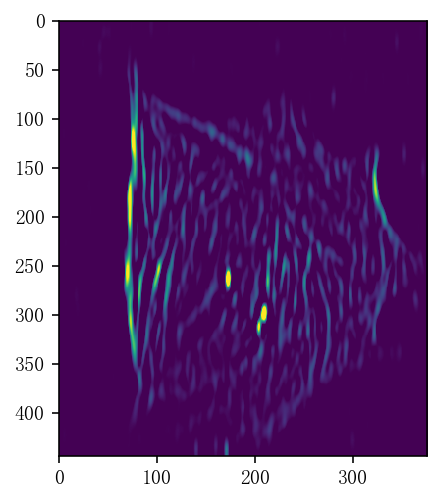

In [24]:
fig = plt.figure('Combined Filter result')
ax = fig.add_subplot(111)
combined1 = sim.convolve(stressFibers, combined_filter)
ax.imshow(combined1, vmin=0,vmax=0.5*combined1.max())
combined1.min()

##### (d) 为强调水平对象，选取不同的gauss_filter, 重复上面的步骤

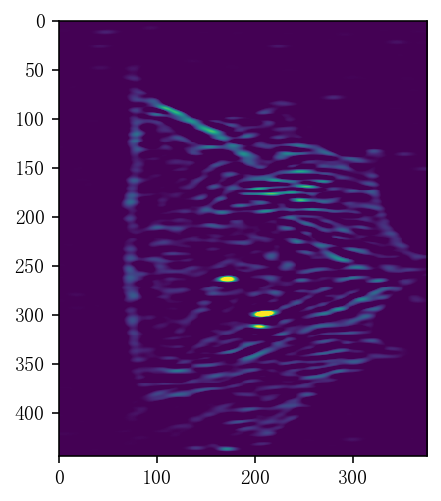

In [25]:
gauss_filter2 = np.exp(-0.5*(X**2/45 + Y**2/5))
laplace_filter=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
combined_filter2 = sim.convolve(gauss_filter2, laplace_filter)
fig = plt.figure('横滤波')
ax = fig.add_subplot(111)
combined2 = sim.convolve(stressFibers, combined_filter2)
ax.imshow(combined2, vmin=0,vmax=0.4*combined2.max())

##### 选做实验：创建另外两个滤波器，实现强调相对于垂直+/-45度方向的对象

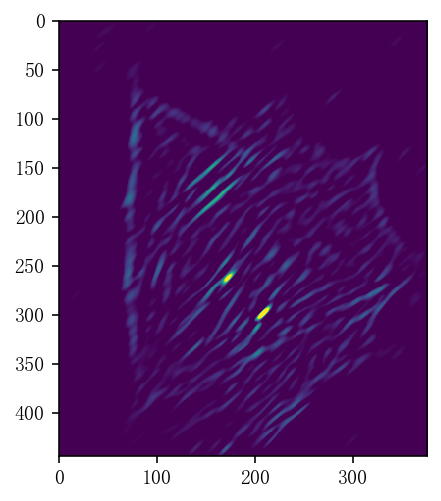

In [26]:
gauss_filter3 = np.exp(-0.5*(X**2/45 + Y**2/5))
laplace_filter=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
combined_filter3 = sim.convolve(gauss_filter2, laplace_filter)
rotate_combined_filter3 = sim.rotate(combined_filter3, 45)
fig = plt.figure('45度滤波')
ax = fig.add_subplot(111)
combined3 = sim.convolve(stressFibers, rotate_combined_filter3)
ax.imshow(combined3, vmin=0, vmax = 0.5*combined3.max())

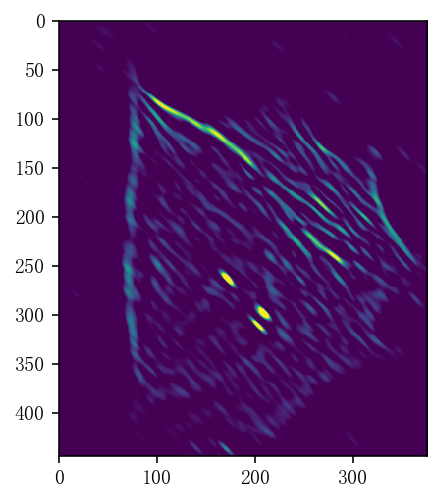

In [27]:
gauss_filter4 = np.exp(-0.5*(X**2/45 + Y**2/5))
laplace_filter=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
combined_filter4 = sim.convolve(gauss_filter4, laplace_filter)
rotate_combined_filter4 = sim.rotate(combined_filter4, -45)
fig = plt.figure('-45度滤波')
ax = fig.add_subplot(111)
combined4 = sim.convolve(stressFibers, rotate_combined_filter4)
ax.imshow(combined4, vmin=0, vmax = 0.5*combined4.max())